In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define ordinal encoding for birthweight and gestational age
bw = [
    '<500',
    '500-749',
    '750-999',
    '1000-1249',
    '1250-1499',
    '1500-1749',
     '1750-1999',
    '2000-2499',
    '>2500',
    'UNK'
]
ga = [
    '<=24',
    '25-26',
    '27-28',
    '29-30',
    '31-32',
    '33-34',
    '35-36',
    '>36',
    'UNK'
]

In [3]:
df = pd.read_csv('cohorts/cohort_t12_6.csv')

In [4]:
df['hospital_expire_flag'].value_counts()

hospital_expire_flag
0    1640
1      66
Name: count, dtype: int64

In [5]:
select_labs = [
    'Base Excess',
    'pO2',
    'pCO2',
    'pH',
    # 'Hematocrit',
    # 'White Blood Cells',
    # 'Platelet Count',
]
features = [
    'ga',
    'bw',
    'gender',
    'Base Excess_valuenum',
    # 'pO2_valuenum',
    # 'pCO2_valuenum',
    # 'pH_valuenum',
    # 'Hematocrit_valuenum',
    # 'White Blood Cells_valuenum',
    # 'Platelet Count_valuenum',
    # 'Base Excess_count',
    'pO2_count',
    'pCO2_count',
    'pH_count',
    # 'Hematocrit_count',
    # 'White Blood Cells_count',
    # 'Platelet Count_count',
]
features_to_scale = [
    'Base Excess_valuenum',
    # 'pO2_valuenum',
    # 'pCO2_valuenum',
    # 'pH_valuenum',
    # 'Hematocrit_valuenum',
    # 'White Blood Cells_valuenum',
    # 'Platelet Count_valuenum',
    # 'Base Excess_count',
    'pO2_count',
    'pCO2_count',
    'pH_count',
    # 'Hematocrit_count',
    # 'White Blood Cells_count',
    # 'Platelet Count_count',
]

In [6]:
''' 
data_split: returns features (X) and labels (y) for three non-overlapping subsets of the given data frame
'''
def data_split(df, features, train_split, holdout_anchor_year_group):
    # Select specified features
    df = df[['subject_id', 'hospital_expire_flag', 'anchor_year_group'] + features]
    
    # Split dataset into training and testing subsets by time (de-identified temporal proxy is anchor_year_group, holdout on future samples)
    test_df = df[df['anchor_year_group'] == holdout_anchor_year_group].drop('anchor_year_group', axis=1)
    train_df = df[df['anchor_year_group'] != holdout_anchor_year_group].drop('anchor_year_group', axis=1)
    
    # Split data frames into features and labels
    X = train_df.drop(['subject_id', 'hospital_expire_flag'], axis=1)
    X_test = test_df.drop(['subject_id', 'hospital_expire_flag'], axis=1)
    y = train_df['hospital_expire_flag']
    y_test = test_df['hospital_expire_flag']

    # Split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1-train_split, random_state=42, stratify=y)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = data_split(df, features, train_split=0.8, holdout_anchor_year_group='2017 - 2019')

In [7]:
def impute_ga_bw(X):
    X['bw_imp'] = X['bw'].fillna(X.groupby('ga')['bw'].transform(lambda x: x[x.notna()].mode().iloc[0]))
    X['ga_imp'] = X['ga'].fillna(X.groupby('bw')['ga'].transform(lambda x: x[x.notna()].mode().iloc[0]))
    X = X.drop(['bw', 'ga'], axis=1)
    return X

In [8]:
def encode_ga_bw(X, bw, ga):
    bw_encoding = {bucket: idx for idx, bucket in enumerate(bw)}
    ga_encoding = {bucket: idx for idx, bucket in enumerate(ga)}
    X['bw_enc'] = X['bw_imp'].map(bw_encoding)
    X['ga_enc'] = X['ga_imp'].map(ga_encoding)
    X = X.drop(['bw_imp', 'ga_imp'], axis=1)
    return X

In [9]:
def encode_gender(X):
    X['gender'] = X['gender'].apply(lambda x: 1 if x == 'M' else 0)
    return X

In [10]:
def impute_lab_values(X, select_labs):
    for lab in select_labs:
        lab_col = f'{lab}_valuenum'
        if lab_col in X: X[lab_col] = X[lab_col].fillna(X[lab_col].mean())
    return X
    
def impute_lab_flags(X, select_labs):
    for lab in select_labs:
        lab_col = f'{lab}_flag'
        if lab_col in X: X[lab_col] = X[lab_col].fillna('normal')
    return X

In [11]:
def fit_scale(X, scaler, features_to_scale):
    X[features_to_scale] = scaler.fit_transform(X[features_to_scale])

def scale(X, scaler, features_to_scale):
    X[features_to_scale] = scaler.transform(X[features_to_scale])

In [12]:
def smote(X, y, sampling_strategy=0.3):
    smote = SMOTE(sampling_strategy=sampling_strategy) 
    X_upsampled, y_upsampled = smote.fit_resample(X, y)
    return X_upsampled, y_upsampled

In [13]:
scaler = StandardScaler()
X_train = encode_ga_bw(impute_ga_bw(X_train), bw, ga)
X_train = encode_gender(X_train)
X_train = impute_lab_values(X_train, select_labs)
fit_scale(X_train, scaler, features_to_scale)

In [14]:
# X_train, y_train = smote(X_train, y_train, sampling_strategy=0.3)

In [15]:
X_val = encode_ga_bw(impute_ga_bw(X_val), bw, ga)
X_val = encode_gender(X_val)
X_val = impute_lab_values(X_val, select_labs)
scale(X_val, scaler, features_to_scale)

In [16]:
def train_eval(model, X_train, y_train, X_val, y_val, sample_weight=None):
    # Train model
    if sample_weight is None: model.fit(X_train, y_train)
    else: model.fit(X_train, y_train, sample_weight=sample_weight)
    
    # Training metrics
    print("Training:\n")
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:,1]
    print("Accuracy:", accuracy_score(y_train, y_train_pred))
    print("AUC:", roc_auc_score(y_train, y_train_prob))
    print("\nClassification Report:\n", classification_report(y_train, y_train_pred))

    # Validation metrics
    print("\nValidation:\n")
    y_val_pred = model.predict(X_val)
    y_val_prob = model.predict_proba(X_val)[:,1]
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("AUC:", roc_auc_score(y_val, y_val_prob))
    print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

In [17]:
model = LogisticRegression(penalty='l2', solver='liblinear')
train_eval(model, X_train, y_train, X_val, y_val)

Training:

Accuracy: 0.9652650822669104
AUC: 0.8948601303639327

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1052
           1       0.70      0.17      0.27        42

    accuracy                           0.97      1094
   macro avg       0.83      0.58      0.63      1094
weighted avg       0.96      0.97      0.95      1094


Validation:

Accuracy: 0.9598540145985401
AUC: 0.8462121212121213

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       264
           1       0.33      0.10      0.15        10

    accuracy                           0.96       274
   macro avg       0.65      0.55      0.57       274
weighted avg       0.94      0.96      0.95       274



In [18]:
model = LogisticRegression(class_weight='balanced', penalty='l2', solver='liblinear')
train_eval(model, X_train, y_train, X_val, y_val)

Training:

Accuracy: 0.8281535648994516
AUC: 0.9080549520188304

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      1052
           1       0.17      0.86      0.28        42

    accuracy                           0.83      1094
   macro avg       0.58      0.84      0.59      1094
weighted avg       0.96      0.83      0.88      1094


Validation:

Accuracy: 0.8284671532846716
AUC: 0.8375

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90       264
           1       0.15      0.80      0.25        10

    accuracy                           0.83       274
   macro avg       0.57      0.81      0.58       274
weighted avg       0.96      0.83      0.88       274



In [19]:
# Logistic regression feature importance
feature_names = X_train.columns
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance['Absolute_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)
print(feature_importance)

                Feature  Coefficient  Absolute_Coefficient
4              pH_count     1.479108              1.479108
3            pCO2_count    -0.888224              0.888224
1  Base Excess_valuenum    -0.824027              0.824027
5                bw_enc    -0.376553              0.376553
0                gender    -0.324495              0.324495
6                ga_enc    -0.247717              0.247717
2             pO2_count     0.042707              0.042707


In [20]:
model = LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')
train_eval(model, X_train, y_train, X_val, y_val)

Training:

Accuracy: 0.8272394881170019
AUC: 0.908213380409198

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      1052
           1       0.16      0.86      0.28        42

    accuracy                           0.83      1094
   macro avg       0.58      0.84      0.59      1094
weighted avg       0.96      0.83      0.88      1094


Validation:

Accuracy: 0.8284671532846716
AUC: 0.837121212121212

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90       264
           1       0.15      0.80      0.25        10

    accuracy                           0.83       274
   macro avg       0.57      0.81      0.58       274
weighted avg       0.96      0.83      0.88       274



In [21]:
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
train_eval(model, X_train, y_train, X_val, y_val, sample_weight)

Training:

Accuracy: 0.979890310786106
AUC: 0.9989249502082201

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1052
           1       0.66      1.00      0.79        42

    accuracy                           0.98      1094
   macro avg       0.83      0.99      0.89      1094
weighted avg       0.99      0.98      0.98      1094


Validation:

Accuracy: 0.9416058394160584
AUC: 0.768939393939394

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       264
           1       0.25      0.30      0.27        10

    accuracy                           0.94       274
   macro avg       0.61      0.63      0.62       274
weighted avg       0.95      0.94      0.94       274



In [22]:
param_grid = {
    'n_estimators': [5, 10, 25, 50, 100],
    'max_depth': [None, 2, 5, 10, 20],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}

# Create a Random Forest Classifier
rf = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Get the best model
model = grid_search.best_estimator_

Best parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 0.7416666666666666


In [23]:
print("Training:\n")
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:,1]
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("AUC:", roc_auc_score(y_train, y_train_prob))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))

# Validation metrics
print("\nValidation:\n")
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("AUC:", roc_auc_score(y_val, y_val_prob))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Training:

Accuracy: 0.829981718464351
AUC: 0.9124004164403404

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      1052
           1       0.16      0.83      0.27        42

    accuracy                           0.83      1094
   macro avg       0.58      0.83      0.59      1094
weighted avg       0.96      0.83      0.88      1094


Validation:

Accuracy: 0.8357664233576643
AUC: 0.8793560606060606

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91       264
           1       0.14      0.70      0.24        10

    accuracy                           0.84       274
   macro avg       0.56      0.77      0.57       274
weighted avg       0.96      0.84      0.88       274



                Feature  Gini Importance
6                ga_enc         0.324241
5                bw_enc         0.205104
2             pO2_count         0.179256
3            pCO2_count         0.109158
4              pH_count         0.100472
1  Base Excess_valuenum         0.071762
0                gender         0.010006


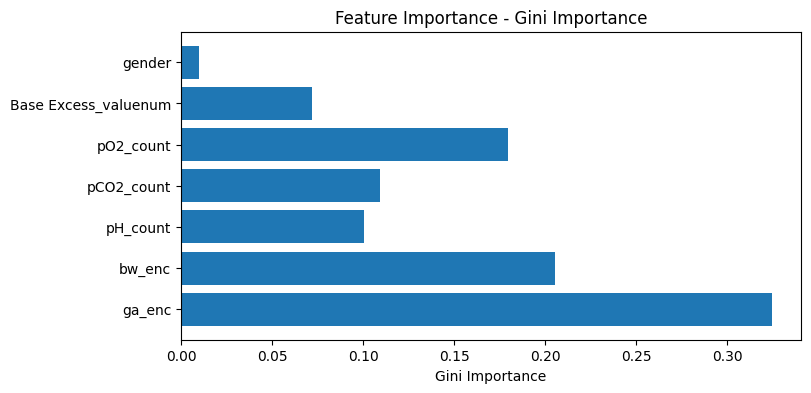

In [24]:
# Random forest feature importance
feature_names = X_train.columns
importances = model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
print(feature_imp_df)

plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances)
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.show()

In [25]:
brf = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [5, 10, 25, 50, 100],
    'max_depth': [None, 2, 5, 10, 20],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    brf,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
Best score: 0.8583333333333332


In [26]:
print("Training:\n")
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:,1]
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("AUC:", roc_auc_score(y_train, y_train_prob))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))

# Validation metrics
print("\nValidation:\n")
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("AUC:", roc_auc_score(y_val, y_val_prob))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Training:

Accuracy: 0.8537477148080439
AUC: 0.9281414086547166

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      1052
           1       0.19      0.86      0.31        42

    accuracy                           0.85      1094
   macro avg       0.59      0.86      0.61      1094
weighted avg       0.96      0.85      0.89      1094


Validation:

Accuracy: 0.8503649635036497
AUC: 0.8721590909090909

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92       264
           1       0.16      0.70      0.25        10

    accuracy                           0.85       274
   macro avg       0.57      0.78      0.59       274
weighted avg       0.96      0.85      0.89       274

